# 6th Model training : CNNS
In this notebook we train a cnn to denoise our BCPPMCHURN data and feed its embeddings to an xgboost model

In [4]:
#Change working directory to project direcgtory
import os

current_directory = os.getcwd()
project_name = 'bcppmchurn'
project_path = os.path.join(current_directory.split(project_name)[0], project_name)
os.chdir(project_path)
print(os.getcwd())  

/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn


In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from datetime import datetime 
import random
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb
import torch
import torch.nn.functional as F
import pickle 
import json

from src.logger import logging
from src.logger_class import setup_logger
from src.eda import utils
from src.eda.utils import columnsFamilies

In [6]:
#Get todays's date
date_time = datetime.today().strftime("%Y-%m-%d")
#Declare paths
train_dev_test_path = "data/train_dev_test"
data_path = "data/experiments_data"
data_samples_path = "data/data_samples"
artifacts_path = "artifacts/eda"
x_y_sets_path = "data/x_y_sets"
models_path = "models/ml_models"
models_ressources_path = "models/ressources"

### Loading data 

------------------------

In [7]:
#Loading data
data_date = "2024-10-22"
x_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_train_norm.csv", index_col = 0)
x_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_dev_norm.csv", index_col = 0)
x_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_test_norm.csv", index_col = 0)
y_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_train.csv", index_col = 0)
y_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_dev.csv", index_col = 0)
y_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_test.csv", index_col = 0)

print (f"x_train shape : {x_train.shape}")
print (f"y_train shape : {y_train.shape}")
print ("------------------")
print (f"x_dev shape : {x_dev.shape}")
print (f"y_dev shape : {y_dev.shape}")
print ("------------------")
print (f"x_test shape : {x_test.shape}")
print (f"y_test shape : {y_test.shape}")

#transform y to array
y_train = y_train.values.flatten()
y_dev = y_dev.values.flatten()
y_test = y_test.values.flatten()
print ("------------------")
print (f"y_train length : {len(y_train)}")
print (f"y_dev length : {len(y_dev)}")
print (f"y_test length : {len(y_test)}")

x_train shape : (86992, 531)
y_train shape : (86992, 1)
------------------
x_dev shape : (14563, 531)
y_dev shape : (14563, 1)
------------------
x_test shape : (5839, 531)
y_test shape : (5839, 1)
------------------
y_train length : 86992
y_dev length : 14563
y_test length : 5839


---------------------------

### Build and train an autoencoder

Prepare data 

In [8]:
#Set seed 
np.random.seed(0)

In [9]:
def df_to_torch_tensor(df):
     """
     Transform a pandas dataframe to a torch tensor batch by batch
     """
     df_tensor_list = []
     for i in range(0,len(df), 50 ):
          if type(df) == pd.core.frame.DataFrame:
               tensor = torch.tensor(df[i:i+50].values, dtype=torch.float32)
          elif type(df) == np.ndarray:
               tensor = torch.tensor(df[i:i+50], dtype=torch.float32)

          df_tensor_list.append(tensor)
          if i%10000 == 0 and i>0:
               print (f"i = {i}, Processed 10000 points of data")
     df_tensor = torch.cat(df_tensor_list, dim=0)
     return df_tensor

In [10]:
#transform data to a pytorch tensor 
x_train_tensor = df_to_torch_tensor(x_train)
x_dev_tensor = df_to_torch_tensor(x_dev)
x_test_tensor = df_to_torch_tensor(x_test)

y_train_tensor = df_to_torch_tensor(y_train)
y_dev_tensor = df_to_torch_tensor(y_dev)
y_test_tensor = df_to_torch_tensor(y_test)

i = 10000, Processed 10000 points of data
i = 20000, Processed 10000 points of data
i = 30000, Processed 10000 points of data
i = 40000, Processed 10000 points of data
i = 50000, Processed 10000 points of data
i = 60000, Processed 10000 points of data
i = 70000, Processed 10000 points of data
i = 80000, Processed 10000 points of data
i = 10000, Processed 10000 points of data
i = 10000, Processed 10000 points of data
i = 20000, Processed 10000 points of data
i = 30000, Processed 10000 points of data
i = 40000, Processed 10000 points of data
i = 50000, Processed 10000 points of data
i = 60000, Processed 10000 points of data
i = 70000, Processed 10000 points of data
i = 80000, Processed 10000 points of data
i = 10000, Processed 10000 points of data


build the cnn 

In [11]:
#Build model class
class ConvolutionalNet(torch.nn.Module):
    def __init__(self, input_shape):
        super(ConvolutionalNet, self).__init__()
        self.input_shape = input_shape
        self.nbr_channels_1 = 8
        self.nbr_channels_2 = 16
        
        # Encoder
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.LazyLinear(out_features=50)  # Lazy initializes in_features
        
        # Decoder
        self.linear2 = torch.nn.Linear(50, 16992)  # Will adapt based on encoder output
        self.unflatten = torch.nn.Unflatten(dim=1, unflattened_size=(32, 1, 531))  # Dynamically reshapes
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.linear3 = torch.nn.LazyLinear(out_features=input_shape[1])  # Final layer outputs original feature count

    def encoder(self, x):
        # Track dimensions with prints
        x = x.view(-1, 1, 1, self.input_shape[1]) #(1, 1, 1, 531)
        x = F.relu(self.conv1(x))                 #(1, 16, 1, 531)
        x = F.relu(self.conv2(x))                 #(1, 32, 1, 531)
        x = self.flatten(x)                       #(1, 32 × 1 × 531) = (1, 16992)
        x = F.relu(self.linear1(x))               #(1, 50)
        return x
    
    def decoder(self, x):
        # Pass through linear layer and reshape for deconvolution
        x = F.relu(self.linear2(x))             #(1, 16992)
        x = self.unflatten(x)                   #(1, 32, 1, 531)
        x = F.relu(self.conv3(x))               #(1, 16, 1, 531)
        x = F.relu(self.conv4(x))               #(1, 1, 1, 531)
        x = self.flatten(x)                     #(1, 531)
        x = self.linear3(x)                     #(1, 531)
        return x
    
    def forward(self, x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded

In [12]:
#Initialization
eval_hist = {'train_loss': [], 'dev_loss':[]}
input_shape = x_train_tensor.shape
CONVOLUTIONAL_NET = ConvolutionalNet(input_shape)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(CONVOLUTIONAL_NET.parameters(), lr=0.01)

In [ ]:
print (f"Total number of parameters: {sum (p.numel() for p in CONVOLUTIONAL_NET.parameters())}")
print (f"Total number of trainnable parameters: {sum (p.numel() for p in CONVOLUTIONAL_NET.parameters() if p.requires_grad)}") 

In [13]:
#device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "mps"
CONVOLUTIONAL_NET.to(device)
x_train_tensor, x_dev_tensor, x_test_tensor = x_train_tensor.to(device), x_dev_tensor.to(device), x_test_tensor.to(device)

In [14]:
half = x_train_tensor.shape[0]//2
x_train_tensor_1 = x_train_tensor[:half, :]
x_dev_tensor_1 = x_train_tensor[:half, :]
x_train_tensor_2 = x_train_tensor[half:, :]
x_dev_tensor_2 = x_train_tensor[half:, :]

In [15]:
#Training 
num_epochs = 200
for epoch in range(1, num_epochs+1):
    train_output = CONVOLUTIONAL_NET(x_train_tensor_2)
    train_loss = criterion(train_output, x_train_tensor_2)
    optimizer.zero_grad()
    train_loss.backward()
    #Optimizer
    optimizer.step()
    #DEV loss
    with torch.no_grad():
        dev_output = CONVOLUTIONAL_NET(x_dev_tensor_2)
        dev_loss = criterion(dev_output, x_dev_tensor_2)
    #Add loss to loss hisltory
    eval_hist["train_loss"].append(train_loss.item())
    eval_hist["dev_loss"].append(dev_loss.item())   

    #Track loss every 10 epochs 
    print (f"epoch = [{epoch}/{num_epochs}]-------------- "
               f"train_loss : {train_loss.item():4f} ------------ "
               f"dev_loss : {dev_loss.item():4f}")

epoch = [1/200]-------------- train_loss : 16647011764319289344.000000 ------------ dev_loss : 15345155912172044288.000000
epoch = [2/200]-------------- train_loss : 15300852190642438144.000000 ------------ dev_loss : 11943912349158604800.000000
epoch = [3/200]-------------- train_loss : 11964605157993349120.000000 ------------ dev_loss : 110455143723400429568.000000
epoch = [4/200]-------------- train_loss : 108307577612028346368.000000 ------------ dev_loss : 6253335493778341888.000000
epoch = [5/200]-------------- train_loss : 6247365695395332096.000000 ------------ dev_loss : 10297196873982672896.000000
epoch = [6/200]-------------- train_loss : 10281178089077604352.000000 ------------ dev_loss : 13577258862452408320.000000
epoch = [7/200]-------------- train_loss : 13557518230687318016.000000 ------------ dev_loss : 15052867238602211328.000000
epoch = [8/200]-------------- train_loss : 15041301475789635584.000000 ------------ dev_loss : 15861754853412831232.000000
epoch = [9/200]-

In [16]:
#Training 
num_epochs = 200
for epoch in range(1, num_epochs+1):
    train_output = CONVOLUTIONAL_NET(x_train_tensor_1)
    train_loss = criterion(train_output, x_train_tensor_1)
    optimizer.zero_grad()
    train_loss.backward()
    #Optimizer
    optimizer.step()
    #DEV loss
    with torch.no_grad():
        dev_output = CONVOLUTIONAL_NET(x_dev_tensor_1)
        dev_loss = criterion(dev_output, x_dev_tensor_1)
    #Add loss to loss hisltory
    eval_hist["train_loss"].append(train_loss.item())
    eval_hist["dev_loss"].append(dev_loss.item())   

    #Track loss every 10 epochs 
    print (f"epoch = [{epoch}/{num_epochs}]-------------- "
               f"train_loss : {train_loss.item():4f} ------------ "
               f"dev_loss : {dev_loss.item():4f}")

epoch = [1/200]-------------- train_loss : 1207217450370727936.000000 ------------ dev_loss : 1224773902287241216.000000
epoch = [2/200]-------------- train_loss : 1205278186737238016.000000 ------------ dev_loss : 1221535565665533952.000000
epoch = [3/200]-------------- train_loss : 1203067756048547840.000000 ------------ dev_loss : 1219866094697709568.000000
epoch = [4/200]-------------- train_loss : 1200589456839540736.000000 ------------ dev_loss : 1216736334849245184.000000
epoch = [5/200]-------------- train_loss : 1197902662738116608.000000 ------------ dev_loss : 1213573727090900992.000000
epoch = [6/200]-------------- train_loss : 1195040221654155264.000000 ------------ dev_loss : 1211059006559223808.000000
epoch = [7/200]-------------- train_loss : 1192130226692292608.000000 ------------ dev_loss : 1207008543161450496.000000
epoch = [8/200]-------------- train_loss : 1189053243401961472.000000 ------------ dev_loss : 1205578490850574336.000000
epoch = [9/200]-------------- tr

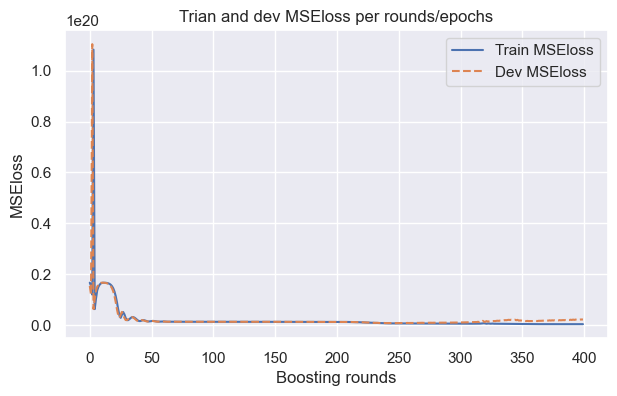

In [17]:
#Plot loss
utils.vis_training_metric(eval_hist, eval_metric="MSEloss")

In [18]:
with torch.no_grad():
    autoencoder_test_data = CONVOLUTIONAL_NET(x_test_tensor)
autoencoder_test_data_numpy = autoencoder_test_data.cpu().detach().numpy()
x_test_tensor_numpy = x_test_tensor.cpu().detach().numpy()
mse = mean_squared_error(x_test_tensor_numpy, autoencoder_test_data_numpy)
mae = mean_absolute_error(x_test_tensor_numpy, autoencoder_test_data_numpy)
print (f"R2 score : {r2_score(x_test_tensor_numpy, autoencoder_test_data_numpy)}") 
print (f"MSE : {mse}")
print (f"MAE : {mae}") 

R2 score : -1.285986600823554e+20
MSE : 9.686720310548418e+19
MAE : 4827666944.0


In [19]:
#Unoise data and transform it to numpy
#columns = [f"x{i}" for i in range(1, 11)]
def encode_data(AUTOENCODER, x_train_tensor, x_dev_tensor, x_test_tensor):
    with torch.no_grad():
        encoded_train_data = AUTOENCODER.encoder(x_train_tensor)
        encoded_train_data = encoded_train_data.cpu().detach().numpy()
        encoded_train_data = pd.DataFrame(encoded_train_data )
        encoded_dev_data = AUTOENCODER.encoder(x_dev_tensor)
        encoded_dev_data = encoded_dev_data.cpu().detach().numpy()
        encoded_dev_data = pd.DataFrame(encoded_dev_data)
        encoded_test_data = AUTOENCODER.encoder(x_test_tensor)
        encoded_test_data = encoded_test_data.cpu().detach().numpy()
        encoded_test_data = pd.DataFrame(encoded_test_data)

    print( f"train shape : {encoded_train_data.shape}")
    print( f"dev shape : {encoded_dev_data.shape}")
    print( f"test shape : {encoded_test_data.shape}")
    return encoded_train_data, encoded_dev_data, encoded_test_data

In [20]:
CONVOLUTIONAL_NET.to(device)
x_train_tensor_1, x_train_tensor_2 = x_train_tensor_1.to(device), x_train_tensor_2.to(device)

In [21]:
encoded_train_data_1, encoded_dev_data, encoded_test_data = encode_data(CONVOLUTIONAL_NET, x_train_tensor_1, x_dev_tensor, x_test_tensor)
encoded_train_data_2, encoded_dev_data, encoded_test_data = encode_data(CONVOLUTIONAL_NET, x_train_tensor_2, x_dev_tensor, x_test_tensor)
encoded_train_data = pd.concat([encoded_train_data_1, encoded_train_data_2])

train shape : (43496, 50)
dev shape : (14563, 50)
test shape : (5839, 50)
1
train shape : (43496, 50)
dev shape : (14563, 50)
test shape : (5839, 50)
2


### Train XGBoost on encoder output data (encoded data)

In [34]:
dtrain = xgb.DMatrix(data=encoded_train_data, label=y_train_tensor)
ddev = xgb.DMatrix(data=encoded_dev_data, label=y_dev_tensor)
dtest = xgb.DMatrix(data=encoded_test_data, label=y_test_tensor)
evals = [(dtrain, "train"), (ddev, "dev")]

In [35]:
#Parameters 
params = {
    'learning_rate':0.001,
    'eta':0.1,
    'max_depth':6,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'gamma':0.1,
    'subsample': 0.9,                 
    'colsample_bytree': 1,           
    'min_child_weight': 1,     
    'scale_pos_weight': 1,   
}

In [36]:
#Initialize and train model
xgb_eval_hist = {}
XGB_MODEL = 0
XGB_MODEL = xgb.train(  params=params, 
                        dtrain=dtrain, 
                        num_boost_round=20000,
                        evals=evals,
                        early_stopping_rounds=50, 
                        evals_result=xgb_eval_hist, 
                        verbose_eval=True
                     )

[0]	train-logloss:0.69284	dev-logloss:0.69284
[1]	train-logloss:0.69255	dev-logloss:0.69256
[2]	train-logloss:0.69227	dev-logloss:0.69228
[3]	train-logloss:0.69197	dev-logloss:0.69200
[4]	train-logloss:0.69168	dev-logloss:0.69171
[5]	train-logloss:0.69139	dev-logloss:0.69142
[6]	train-logloss:0.69109	dev-logloss:0.69113
[7]	train-logloss:0.69080	dev-logloss:0.69085
[8]	train-logloss:0.69051	dev-logloss:0.69057
[9]	train-logloss:0.69022	dev-logloss:0.69028
[10]	train-logloss:0.68994	dev-logloss:0.69000
[11]	train-logloss:0.68965	dev-logloss:0.68972
[12]	train-logloss:0.68936	dev-logloss:0.68943
[13]	train-logloss:0.68907	dev-logloss:0.68915
[14]	train-logloss:0.68878	dev-logloss:0.68887
[15]	train-logloss:0.68850	dev-logloss:0.68859
[16]	train-logloss:0.68821	dev-logloss:0.68831
[17]	train-logloss:0.68792	dev-logloss:0.68803
[18]	train-logloss:0.68764	dev-logloss:0.68775
[19]	train-logloss:0.68736	dev-logloss:0.68748
[20]	train-logloss:0.68707	dev-logloss:0.68720
[21]	train-logloss:0.68

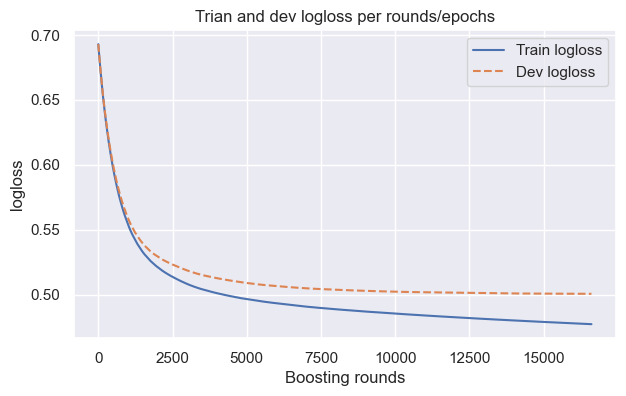

In [37]:
#Plot eval metric
utils.vis_training_metric(xgb_eval_hist, eval_metric="logloss")

In [38]:
#Predictions
y_test_predicted_prob = XGB_MODEL.predict(dtest)
y_train_predicted_prob = XGB_MODEL.predict(dtrain)
#Transform probas into predictions
THRESHOLD = 0.5
y_test_pred = [int(y_test_predicted_prob[i]>THRESHOLD) for i in range(len(y_test_predicted_prob))]
y_train_pred = [int(y_train_predicted_prob[i]>THRESHOLD) for i in range(len(y_train_predicted_prob))]

                  train set      ||     test set
------------------------------------------------------------
xgboost accuracy    : 0.7868884495125988  ||  0.7711936975509505
xgboost precision   : 0.8422240961888958  ||  0.8299011532125206
xgboost recall      : 0.7084897025171625  ||  0.6858407079646017
xgboost f1 score    : 0.7695902362635314  ||  0.7510249720462169
-------------------------------------------------------------


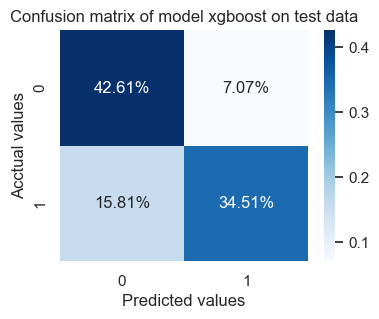

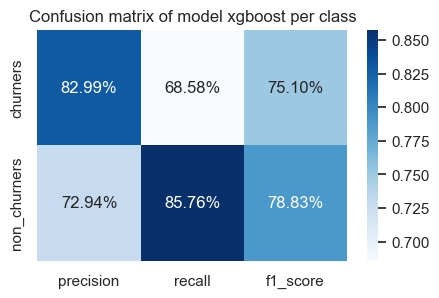

In [39]:
#Visualize model performance
utils.report_model_performances(y_train, y_train_pred, y_test, y_test_pred, model_name = "xgboost")

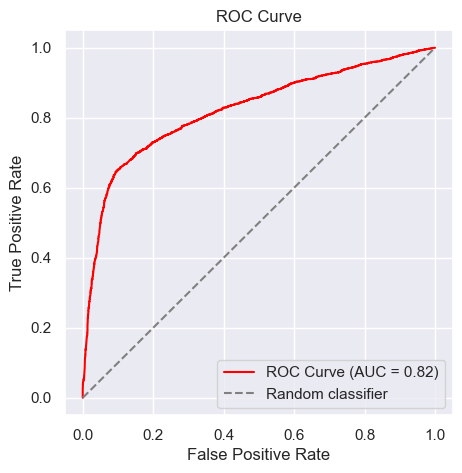

In [40]:
#Plot roc curve 
utils.vis_roc_curve(y_test, y_test_predicted_prob)

Ploting data distribution


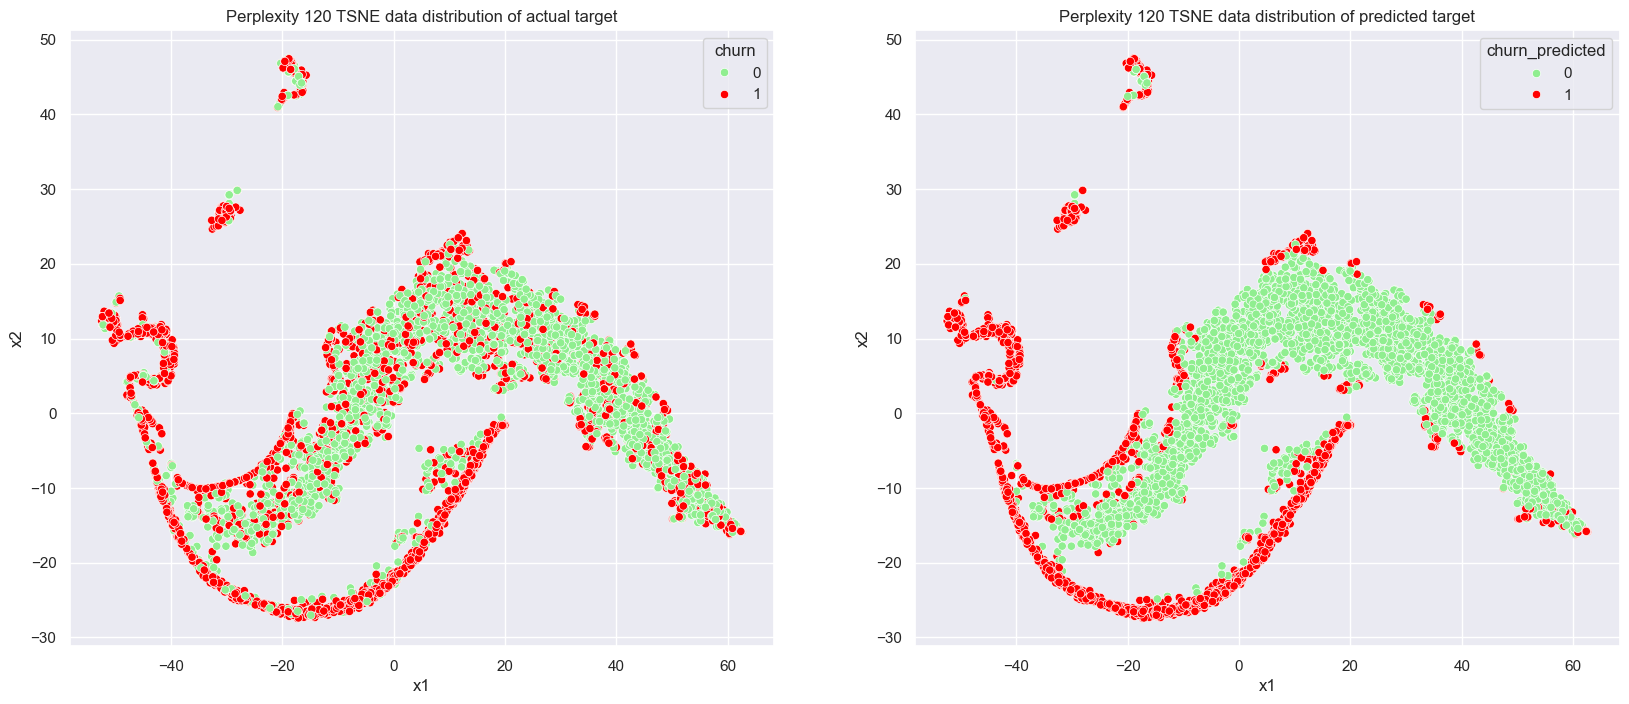

In [41]:
#Apply tsne for data distribution visualization
from sklearn.manifold import TSNE

data_tsne = TSNE(n_components = 2, perplexity = 120).fit_transform(encoded_test_data)
data_tsne = pd.DataFrame(data_tsne, columns = ["x1", "x2"])
data_tsne["churn"] = y_test
data_tsne["churn_predicted"] = y_test_pred

#Plot
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10*2, 8))
#Plot
print ("Ploting data distribution")
sns.set_theme()
sns.scatterplot(data = data_tsne, x="x1", y="x2", hue = "churn", ax=axes[0], palette=["lightgreen", "red"])
axes[0].set_title("Perplexity 120 TSNE data distribution of actual target")
sns.scatterplot(data = data_tsne, x="x1", y="x2", hue = "churn_predicted", ax=axes[1], palette=["lightgreen", "red"])
axes[1].set_title("Perplexity 120 TSNE data distribution of predicted target")
plt.show()

Applying tsne on data
Ploting data distribution


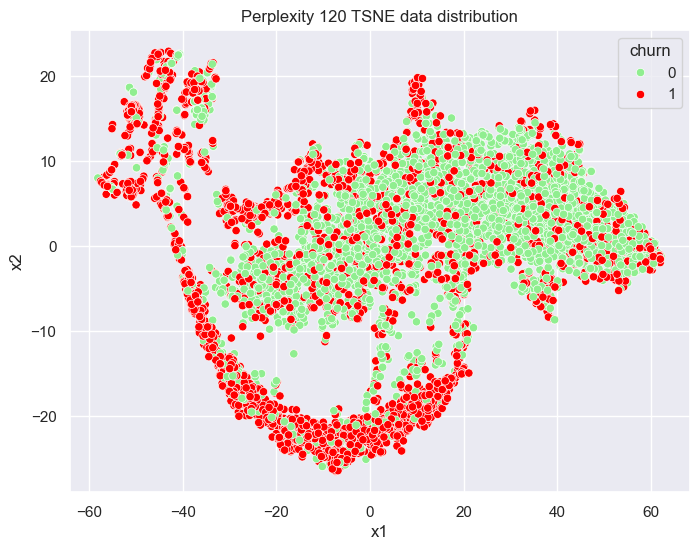

In [123]:
#Original data
utils.vis_tsne_data_distribution(data=x_test, target=y_test, perplexity=120, figsize=(8, 6), palette=["lightgreen", "red"])

### Run this cell if kernel crashes when training the autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Step 1: Simulate some sample data for F1, F2, and F3
# We simulate 1000 samples
np.random.seed(0)
F1 = np.random.normal(10, 2, 1000)  # mean=10, std=2
F2 = np.random.normal(20, 5, 1000)  # mean=20, std=5
F3 = np.random.normal(30, 1, 1000)  # mean=30, std=1

# Stack them into a dataset
data = np.stack([F1, F2, F3], axis=1)
data = torch.tensor(data, dtype=torch.float32)

# Step 2: Add artificial noise to create noisy data for training
noise = 0.5 * torch.randn(data.size())
noisy_data = data + noise

# Step 3: Define a simple denoising autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(3, 2),  # Reducing from 3 to 2 dimensions
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 3)  # Reconstructing back to original 3 dimensions
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model, loss function, and optimizer
model = DenoisingAutoencoder()
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    output = model(noisy_data)
    loss = criterion(output, data)  # Compare output to original, clean data
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 333.7306
Epoch [20/100], Loss: 214.0994
Epoch [30/100], Loss: 101.8112
Epoch [40/100], Loss: 37.4396
Epoch [50/100], Loss: 19.0256
Epoch [60/100], Loss: 11.0660
Epoch [70/100], Loss: 8.3639
Epoch [80/100], Loss: 8.4877
Epoch [90/100], Loss: 8.3024
Epoch [100/100], Loss: 8.1309
